In [2]:
# Install necessary libraries
import json
import pandas as pd
# from google.colab import drive
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
from matplotlib.colors import rgb_to_hsv
from scipy import stats
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize

In [3]:
# Mount:
# drive.mount('/content/drive', force_remount = True)

In [4]:
# Read json file
def readJsonData(JSON_FILE_PATH):
  data = None
  try:
    with open(JSON_FILE_PATH, 'r') as f:
        data = json.load(f)
    print("✅ JSON file loaded successfully.")

    metadata = data.get('metadata', {})
    print(f"\n--- Session Metadata ---")
    for key, value in metadata.items():
        print(f"{key.ljust(20)}: {value}")

  except FileNotFoundError:
      print(f"❌ ERROR: File not found at path: {JSON_FILE_PATH}")
      print("Please check the file path and ensure Google Drive is correctly mounted.")
  except json.JSONDecodeError:
      print("❌ ERROR: Could not decode JSON. Ensure the file is valid.")
  return data

# Preprocessing
def preprocessData(data):
  flat_data = []

  # Extract metadata for easy merging later
  session_metadata = data.get('metadata', {})
  session_name = session_metadata.get('sessionName', 'Unknown Session')

  # Iterate through each sample (color card)
  for sample in data.get('data', []):
      sample_number = sample.get('sampleNumber')

      # Iterate through each measurement (1 to 10) within that sample
      for capture_index, measurement in enumerate(sample.get('measurements', [])):

          # Create a dictionary for the current row
          row = {
              'session_name': session_name,
              'sample_number': sample_number,
              'capture_index': capture_index, # 0 to 9
              'lighting_condition': session_metadata.get('lightingCondition'),
              'reflective_surface': session_metadata.get('useReflectiveSurface'),

              # Sensor Data
              'pitch': measurement['angles']['pitch'],
              'roll': measurement['angles']['roll'],
          }

          # Extract Color Data (White and Color reticles, three radii each)

          # White Reticle Captures
          for radius in [0, 2, 4]:
              capture_key = f'r{radius}'
              color_data = measurement['white'].get(capture_key, {'r': 0, 'g': 0, 'b': 0})
              row[f'white_r{radius}_R'] = color_data['r']
              row[f'white_r{radius}_G'] = color_data['g']
              row[f'white_r{radius}_B'] = color_data['b']

          # Color Reticle Captures
          for radius in [0, 2, 4]:
              capture_key = f'r{radius}'
              color_data = measurement['color'].get(capture_key, {'r': 0, 'g': 0, 'b': 0})
              row[f'color_r{radius}_R'] = color_data['r']
              row[f'color_r{radius}_G'] = color_data['g']
              row[f'color_r{radius}_B'] = color_data['b']

          flat_data.append(row)

  # Convert the list of dictionaries to a Pandas DataFrame
  df = pd.DataFrame(flat_data)

  print(f"\n✅ Data flattened into DataFrame with {len(df)} rows (Total captures: 24 samples * 10 captures = 240 rows).")
  return df

# ## 3. Initial Review and Visualization

# Display the first few rows and the column types for verification.
def displayDataFrameInfo(df):
  print("\n--- DataFrame Head (First 5 Rows) ---")
  print(df.head())

  print("\n--- DataFrame Information ---")
  print(df.info())

  # ### 3.1 Check Sensor Variability

  # This checks the pitch/roll stability across all 240 measurements.
  print("\n--- Sensor Angle Statistics ---")
  print(df[['pitch', 'roll']].describe())

def merge_datasets_for_model(dfs):
    """
    Vertically concatenate multiple datasets.
    All rows are kept. Column names must be consistent.

    Parameters
    ----------
    dfs : list of pd.DataFrame
        List of datasets with identical column structure

    Returns
    -------
    pd.DataFrame
        Combined dataset
    """
    merged_df = pd.concat(dfs, axis=0, ignore_index=True)
    return merged_df



In [5]:
def combineGroundTruth(df):
  ground_truth_data = [
      {'sample_number': 1,  'label': 'Dark Skin',      'gt__R': 115, 'gt__G': 82,  'gt__B': 69},
      {'sample_number': 2,  'label': 'Light Skin',     'gt__R': 204, 'gt__G': 161, 'gt__B': 141},
      {'sample_number': 3,  'label': 'Blue Sky',       'gt__R': 101, 'gt__G': 134, 'gt__B': 179},
      {'sample_number': 4,  'label': 'Foliage',        'gt__R': 89,  'gt__G': 109, 'gt__B': 61},
      {'sample_number': 5,  'label': 'Blue Flower',    'gt__R': 141, 'gt__G': 137, 'gt__B': 194},
      {'sample_number': 6,  'label': 'Bluish Green',   'gt__R': 132, 'gt__G': 228, 'gt__B': 208},
      {'sample_number': 7,  'label': 'Orange',         'gt__R': 249, 'gt__G': 118, 'gt__B': 35},
      {'sample_number': 8,  'label': 'Purplish Blue',  'gt__R': 80,  'gt__G': 91,  'gt__B': 182},
      {'sample_number': 9,  'label': 'Moderate Red',   'gt__R': 222, 'gt__G': 91,  'gt__B': 125},
      {'sample_number': 10, 'label': 'Purple',         'gt__R': 91,  'gt__G': 63,  'gt__B': 123},
      {'sample_number': 11, 'label': 'Yellow Green',   'gt__R': 173, 'gt__G': 232, 'gt__B': 91},
      {'sample_number': 12, 'label': 'Orange Yellow',  'gt__R': 255, 'gt__G': 164, 'gt__B': 26},
      {'sample_number': 13, 'label': 'Blue',           'gt__R': 44,  'gt__G': 56,  'gt__B': 142},
      {'sample_number': 14, 'label': 'Green',          'gt__R': 74,  'gt__G': 148, 'gt__B': 81},
      {'sample_number': 15, 'label': 'Red',            'gt__R': 179, 'gt__G': 42,  'gt__B': 50},
      {'sample_number': 16, 'label': 'Yellow',         'gt__R': 250, 'gt__G': 226, 'gt__B': 21},
      {'sample_number': 17, 'label': 'Magenta',        'gt__R': 191, 'gt__G': 81,  'gt__B': 160},
      {'sample_number': 18, 'label': 'Cyan',           'gt__R': 6,   'gt__G': 142, 'gt__B': 172},
      {'sample_number': 19, 'label': 'White',          'gt__R': 252, 'gt__G': 252, 'gt__B': 252},
      {'sample_number': 20, 'label': 'Neutral 8',      'gt__R': 230, 'gt__G': 230, 'gt__B': 230},
      {'sample_number': 21, 'label': 'Neutral 6.5',    'gt__R': 200, 'gt__G': 200, 'gt__B': 200},
      {'sample_number': 22, 'label': 'Neutral 5',      'gt__R': 143, 'gt__G': 143, 'gt__B': 142},
      {'sample_number': 23, 'label': 'Neutral 3.5',    'gt__R': 100, 'gt__G': 100, 'gt__B': 100},
      {'sample_number': 24, 'label': 'Black',          'gt__R': 50,  'gt__G': 50,  'gt__B': 50},
  ]
  df_gt = pd.DataFrame(ground_truth_data)
  df = pd.merge(df, df_gt, on='sample_number', how='outer')

  return df, df_gt

def generateFinalDataFrame(df_with_gt_columns):
  # Calculate average color and corrected color values per sample_number
  avg_cols_to_compute = [
      'color_r0_R', 'color_r0_G', 'color_r0_B',
      'correction_r0_R', 'correction_r0_G', 'correction_r0_B',
      'color_r2_R', 'color_r2_G', 'color_r2_B',
      'correction_r2_R', 'correction_r2_G', 'correction_r2_B',
      'color_r4_R', 'color_r4_G', 'color_r4_B',
      'correction_r4_R', 'correction_r4_G', 'correction_r4_B'
  ]
  df_avg = df_with_gt_columns.groupby('sample_number')[avg_cols_to_compute].mean().reset_index()

  # Rename columns to 'avg_...' to clearly distinguish them
  new_avg_columns_map = {col: 'avg_' + col for col in avg_cols_to_compute}
  df_avg = df_avg.rename(columns=new_avg_columns_map)

  # Merge the df (which now has ground truth) with the averaged color data
  df_final_comparison = pd.merge(df_with_gt_columns, df_avg, on='sample_number', how='left')

  return df_final_comparison

In [6]:
# Merge datasets for training
data1 = readJsonData('Data/ambient_blue.json')
df1 = preprocessData(data1)
df1, _ = combineGroundTruth(df1)
data2 = readJsonData('Data/Zhi2.json')
df2 = preprocessData(data2)
df2, _ = combineGroundTruth(df2)
data3 = readJsonData('Data/Baisu1.json')
df3 = preprocessData(data3)
df3, _ = combineGroundTruth(df3)
df_train = merge_datasets_for_model([df3])

# Preprocessing testing data
# jsonFilePath = 'Data/ambient_green.json'
# data = readJsonData(jsonFilePath)
# df = preprocessData(data)
# df, _ = combineGroundTruth(df)
df = df_train

✅ JSON file loaded successfully.

--- Session Metadata ---
sessionName         : ambient_blue
lightingCondition   : 12
useReflectiveSurface: False
dateTime            : 2025-12-02T22:49:03.937941

✅ Data flattened into DataFrame with 240 rows (Total captures: 24 samples * 10 captures = 240 rows).
✅ JSON file loaded successfully.

--- Session Metadata ---
sessionName         : Zhi_02 
lightingCondition   : 5
useReflectiveSurface: True
dateTime            : 2025-11-19T15:47:32.923269

✅ Data flattened into DataFrame with 240 rows (Total captures: 24 samples * 10 captures = 240 rows).
✅ JSON file loaded successfully.

--- Session Metadata ---
sessionName         : baisu1
lightingCondition   : 0
useReflectiveSurface: False
dateTime            : 2025-11-19T15:01:46.558942

✅ Data flattened into DataFrame with 240 rows (Total captures: 24 samples * 10 captures = 240 rows).


## Method: Using Polynomial Correction:  

The correction method uses three-channel polynomial regression:

$$
\hat{H} = f_H(H_m, S_m, V_m), \quad
\hat{S} = f_S(H_m, S_m, V_m), \quad
\hat{V} = f_V(H_m, S_m, V_m)
$$

where $H_m, S_m, V_m$ are the measured HSV values, and $f_H, f_S, f_V$ are polynomial functions.  

In matrix form:

$$
\hat{C} = X \cdot \Theta, \quad
X = [H_m^1, \dots, H_m^d, \; S_m^1, \dots, S_m^d, \; V_m^1, \dots, V_m^d]
$$

where $d$ is the polynomial degree, $\Theta$ is the coefficient vector, and $\hat{C} = [\hat{H}, \hat{S}, \hat{V}]$.

In [7]:
# ============================================================
# Design matrix: polynomial terms with Hue sin/cos
# ============================================================
def build_design_matrix(measured_h, measured_s, measured_v, degree):
    """
    Build design matrix using all HSV channels.
    Hue is converted to sin/cos to handle circular nature.
    One shared constant term + polynomial terms starting from power 1.

    Returns:
        X: (N, 1 + 4*degree)
           [1, cos(H)^1..^d, sin(H)^1..^d, S^1..^d, V^1..^d]
    """
    N = len(measured_h)
    bias = np.ones((N, 1))

    # convert Hue to sin/cos
    h_rad = measured_h * 2 * np.pi
    h_cos = np.cos(h_rad)
    h_sin = np.sin(h_rad)

    # polynomial terms
    X_h_cos = np.vstack([h_cos**k for k in range(1, degree + 1)]).T
    X_h_sin = np.vstack([h_sin**k for k in range(1, degree + 1)]).T
    X_s = np.vstack([measured_s**k for k in range(1, degree + 1)]).T
    X_v = np.vstack([measured_v**k for k in range(1, degree + 1)]).T

    X = np.hstack([bias, X_h_cos, X_h_sin, X_s, X_v])
    return X


def regression_loss(theta, X, y, channel, reg_lambda=1e-3):
    """
    Regression loss for a single HSV channel.
    - MSE for H (circular), S/V (linear)
    - L2 regularization
    - S/V penalty only if values go below 0 or above 1
    """
    pred = X @ theta

    if channel == 'H':
        # Circular Hue distance
        hue_diff = np.minimum(np.abs(pred - y), 1 - np.abs(pred - y))
        mse = np.mean(hue_diff**2)
    else:
        mse = np.mean((pred - y)**2)

    reg = reg_lambda * np.sum(theta**2)

    # S/V hard boundary penalty (only penalize outside [0,1])
    if channel in ['S', 'V']:
        lower_bound = 0.0
        upper_bound = 1.0
        penalty_low = np.mean(np.maximum(lower_bound - pred, 0.0)**2)
        penalty_high = np.mean(np.maximum(pred - upper_bound, 0.0)**2)
        penalty = reg_lambda * (penalty_low + penalty_high)
    else:
        penalty = 0

    return mse + reg + penalty

# ============================================================
# Optimize one color channel
# ============================================================
def fit_single_channel(measured_h, measured_s, measured_v, gt, degree, ch):
    """
    Fit polynomial model for one HSV channel using all channels.
    """
    X = build_design_matrix(measured_h, measured_s, measured_v, degree)
    # initial guess
    theta0 = np.zeros(X.shape[1])
    # roughly identity mapping for self channel
    theta0[1] = 1.0

    result = minimize(
        regression_loss,
        theta0,
        args=(X, gt, ch),
        method="L-BFGS-B"
    )
    pred = X @ result.x
    if ch == 'H':
        hue_diff = np.minimum(np.abs(pred - gt), 1 - np.abs(pred - gt))
        final_mse = np.mean(hue_diff**2)
    else:
        final_mse = mean_squared_error(gt, pred)
    return {
        "theta": result.x,
        "success": result.success,
        "final_mse": final_mse
    }

def fit_hsv_polynomial(
    df,
    max_degree=5,
    meas_prefix="color_r4_",
    gt_prefix="gt__"
):
    """
    Fit polynomial regression for RGB channels using all channels as input.
    """
    measured_h = df[f"{meas_prefix}H"].values
    measured_s = df[f"{meas_prefix}S"].values
    measured_v = df[f"{meas_prefix}V"].values

    results = {}

    for ch, gt_col in zip(["H", "S", "V"], ["gt__H", "gt__S", "gt__V"]):
        gt = df[gt_col].values
        best_mse = np.inf
        best_result = None
        best_degree = None
        all_results = {}

        for degree in range(1, max_degree+1):
            res = fit_single_channel(measured_h, measured_s, measured_v, gt, degree, ch)
            all_results[degree] = res

            print("degree",degree,"mse",res["final_mse"])
            if res["success"] and res["final_mse"] < best_mse:
                best_mse = res["final_mse"]
                best_result = res
                best_degree = degree

        results[ch] = {
            "best_degree": best_degree,
            "theta": best_result["theta"],
            "final_mse": best_mse,
            "success": best_result["success"],
            "all_results": all_results
        }
    return results

# ============================================================
# Polynomial correction (all channels)
# ============================================================
def correctByPolynomial(meas_h, meas_s, meas_v, coeffs):
    """
    Correct HSV values using a polynomial model with Hue as sin/cos.
    coeffs: array of shape (num_features,) learned from training
    """
    coeffs = np.asarray(coeffs, dtype=np.float64)

    # ensure all inputs are arrays
    meas_h = np.atleast_1d(np.asarray(meas_h, dtype=np.float64))
    meas_s = np.atleast_1d(np.asarray(meas_s, dtype=np.float64))
    meas_v = np.atleast_1d(np.asarray(meas_v, dtype=np.float64))

    # infer degree from coeffs length
    num_features = len(coeffs)
    degree = (num_features - 1) // 4  # now 4 terms per degree: cos(H), sin(H), S, V
    if 1 + 4 * degree != num_features:
        raise ValueError(f"Inconsistent coeffs length: {num_features}")

    X = build_design_matrix(meas_h, meas_s, meas_v, degree)
    corr = X @ coeffs

    return corr[0] if corr.size == 1 else corr


# ============================================================
# Dispatcher for row-wise correction
# ============================================================
from functools import partial

def apply_correction_dispatcher(row, color_prefix, radius,
                                correction_type,
                                coeffs_H=None, coeffs_S=None, coeffs_V=None):
    meas_h = row[f'{color_prefix}_H']
    meas_s = row[f'{color_prefix}_S']
    meas_v = row[f'{color_prefix}_V']

    # Polynomial correction automatically matches coeffs
    corr_h = correctByPolynomial(meas_h, meas_s, meas_v, coeffs_H)
    corr_s = correctByPolynomial(meas_h, meas_s, meas_v, coeffs_S)
    corr_v = correctByPolynomial(meas_h, meas_s, meas_v, coeffs_V)

    # Clip and convert to integer
    corr_h = np.clip(corr_h, 0, 1)
    corr_s = np.clip(corr_s, 0, 1)
    corr_v = np.clip(corr_v, 0, 1)

    return pd.Series([corr_h, corr_s, corr_v])

# ============================================================
# Main function to apply corrections to DataFrame
# ============================================================
def correctHSV(df, correction_type, coeffs_H=None, coeffs_S=None, coeffs_V=None):
    """
    Apply correction to all r0, r2, r4 columns in DataFrame.
    Supports white_scaling or polynomial (all channels)
    """

    partial_apply = partial(
        apply_correction_dispatcher,
        correction_type=correction_type,
        coeffs_H=coeffs_H,
        coeffs_S=coeffs_S,
        coeffs_V=coeffs_V
    )

    for radius in [0, 2, 4]:
        color_prefix = f'color_r{radius}'
        df[[f'correction_r{radius}_H', f'correction_r{radius}_S', f'correction_r{radius}_V']] = df.apply(
            lambda row: partial_apply(row, color_prefix, radius), axis=1
        ).clip(0, 1)

    # Compute MSE for polynomial (r4)
    if correction_type == 'polynomial':
        mse_h = mean_squared_error(df['gt__H'], df['correction_r4_H'])
        mse_s = mean_squared_error(df['gt__S'], df['correction_r4_S'])
        mse_v = mean_squared_error(df['gt__V'], df['correction_r4_V'])
        avg_mse = (mse_h + mse_s + mse_v) / 3.0
        print("\nPolynomial correction MSE (r4):")
        print(f"  H channel MSE: {mse_h:.2f}")
        print(f"  S channel MSE: {mse_s:.2f}")
        print(f"  V channel MSE: {mse_v:.2f}")
        print(f"  Average MSE : {avg_mse:.2f}")

    return df

In [8]:
# ============================================================
# Polynomial correction (all channels)
# ============================================================
def correctByPolynomial(meas_h, meas_s, meas_v, coeffs):
    """
    Correct HSV values using a polynomial model with Hue as sin/cos.
    coeffs: array of shape (num_features,) learned from training
    """
    coeffs = np.asarray(coeffs, dtype=np.float64)

    # ensure all inputs are arrays
    meas_h = np.atleast_1d(np.asarray(meas_h, dtype=np.float64))
    meas_s = np.atleast_1d(np.asarray(meas_s, dtype=np.float64))
    meas_v = np.atleast_1d(np.asarray(meas_v, dtype=np.float64))

    # infer degree from coeffs length
    num_features = len(coeffs)
    degree = (num_features - 1) // 4  # now 4 terms per degree: cos(H), sin(H), S, V
    if 1 + 4 * degree != num_features:
        raise ValueError(f"Inconsistent coeffs length: {num_features}")

    X = build_design_matrix(meas_h, meas_s, meas_v, degree)
    corr = X @ coeffs

    return corr[0] if corr.size == 1 else corr


# ============================================================
# Dispatcher for row-wise correction
# ============================================================
from functools import partial

def apply_correction_dispatcher(row, color_prefix, radius,
                                correction_type,
                                coeffs_H=None, coeffs_S=None, coeffs_V=None):
    meas_h = row[f'{color_prefix}_H']
    meas_s = row[f'{color_prefix}_S']
    meas_v = row[f'{color_prefix}_V']

    # Polynomial correction automatically matches coeffs
    corr_h = correctByPolynomial(meas_h, meas_s, meas_v, coeffs_H)
    corr_s = correctByPolynomial(meas_h, meas_s, meas_v, coeffs_S)
    corr_v = correctByPolynomial(meas_h, meas_s, meas_v, coeffs_V)

    # Clip and convert to integer
    corr_h = np.clip(corr_h, 0, 1)
    corr_s = np.clip(corr_s, 0, 1)
    corr_v = np.clip(corr_v, 0, 1)

    return pd.Series([corr_h, corr_s, corr_v])

# ============================================================
# Main function to apply corrections to DataFrame
# ============================================================
def correctHSV(df, correction_type, coeffs_H=None, coeffs_S=None, coeffs_V=None):
    """
    Apply correction to all r0, r2, r4 columns in DataFrame.
    Supports white_scaling or polynomial (all channels)
    """

    partial_apply = partial(
        apply_correction_dispatcher,
        correction_type=correction_type,
        coeffs_H=coeffs_H,
        coeffs_S=coeffs_S,
        coeffs_V=coeffs_V
    )

    for radius in [0, 2, 4]:
        color_prefix = f'color_r{radius}'
        df[[f'correction_r{radius}_H', f'correction_r{radius}_S', f'correction_r{radius}_V']] = df.apply(
            lambda row: partial_apply(row, color_prefix, radius), axis=1
        ).clip(0, 1)

    # Compute MSE for polynomial (r4)
    if correction_type == 'polynomial':
        mse_h = mean_squared_error(df['gt__H'], df['correction_r4_H'])
        mse_s = mean_squared_error(df['gt__S'], df['correction_r4_S'])
        mse_v = mean_squared_error(df['gt__V'], df['correction_r4_V'])
        avg_mse = (mse_h + mse_s + mse_v) / 3.0
        print("\nPolynomial correction MSE (r4):")
        print(f"  H channel MSE: {mse_h:.2f}")
        print(f"  S channel MSE: {mse_s:.2f}")
        print(f"  V channel MSE: {mse_v:.2f}")
        print(f"  Average MSE : {avg_mse:.2f}")

    return df


In [9]:
import color_conversion
color_conversion.convert_rgb_cols(df, prefix='gt__')
color_conversion.convert_rgb_cols(df, prefix='color_r0_')
color_conversion.convert_rgb_cols(df, prefix='color_r2_')
color_conversion.convert_rgb_cols(df, prefix='color_r4_')
best_result = fit_hsv_polynomial(df, max_degree=10)


best_coeffs_H = best_result["H"]["theta"]
best_coeffs_S = best_result["S"]["theta"]
best_coeffs_V = best_result["V"]["theta"]

df = correctHSV(
    df,
    correction_type='polynomial',
    coeffs_H=best_coeffs_H,
    coeffs_S=best_coeffs_S,
    coeffs_V=best_coeffs_V
)
def rgb_to_hsv_wrapper(r, g, b):
    # Normalize RGB values to [0, 1]
    rgb_normalized = np.array([r, g, b]) / 255.0
    h, s, v = rgb_to_hsv(rgb_normalized)
    return pd.Series([h, s, v])

# Convert original RGB values to HSV and add to DataFrame
rgb_column_sets = [
    ('white', 'r0'), ('white', 'r2'), ('white', 'r4'),
    ('color', 'r0'), ('color', 'r2'), ('color', 'r4'),
    ('gt', '') # This entry needs to be fixed to match the new gt__R naming
]

for prefix, radius in rgb_column_sets:
    # Special handling for ground truth to match the double underscore naming
    if prefix == 'gt':
        r_col, g_col, b_col = 'gt__R', 'gt__G', 'gt__B'
        h_col, s_col, v_col = 'gt__H', 'gt__S', 'gt__V'
    else:
        r_col, g_col, b_col = f'{prefix}_{radius}_R', f'{prefix}_{radius}_G', f'{prefix}_{radius}_B'
        h_col, s_col, v_col = f'{prefix}_{radius}_H', f'{prefix}_{radius}_S', f'{prefix}_{radius}_V'

    df[[h_col, s_col, v_col]] = df.apply(
        lambda row: rgb_to_hsv_wrapper(row[r_col], row[g_col], row[b_col]),
        axis=1, result_type='expand'
    )
displayDataFrameInfo(df)
color_conversion.convert_to_rgb(df, prefix='correction_r0_')
color_conversion.convert_to_rgb(df, prefix='correction_r2_')
color_conversion.convert_to_rgb(df, prefix='correction_r4_')

degree 1 mse 0.03577483602187269
degree 2 mse 0.027294721800317404
degree 3 mse 0.03410554414886744
degree 4 mse 0.019164316084330005
degree 5 mse 0.017283533394310834
degree 6 mse 0.015900062480345978
degree 7 mse 0.015111958301654845
degree 8 mse 0.014482010968172317
degree 9 mse 0.014183675156027196
degree 10 mse 0.014005634288933415
degree 1 mse 0.005622045236454261
degree 2 mse 0.005423864729558444
degree 3 mse 0.004910847560246669
degree 4 mse 0.004844649301237988
degree 5 mse 0.004415880344833467
degree 6 mse 0.004345087347035981
degree 7 mse 0.0040998478790215355
degree 8 mse 0.004058245046476635
degree 9 mse 0.003966569276875905
degree 10 mse 0.003948168667487143
degree 1 mse 0.004325231498970364
degree 2 mse 0.0031192553488735334
degree 3 mse 0.002643323198237263
degree 4 mse 0.002418518563237293
degree 5 mse 0.0020639964498375676
degree 6 mse 0.001943950625309614
degree 7 mse 0.001857548907143074
degree 8 mse 0.0018020127852850095
degree 9 mse 0.0017849965548407348
degree 10

,session_name,sample_number,capture_index,lighting_condition,reflective_surface,pitch,roll,white_r0_R,white_r0_G,white_r0_B,...,white_r4_V,correction_r0_R,correction_r0_G,correction_r0_B,correction_r2_R,correction_r2_G,correction_r2_B,correction_r4_R,correction_r4_G,correction_r4_B
0,baisu1,1,0,0,False,-29.693001,1.293356,171,175,178,...,0.701961,120.0,68.0,99.0,119.0,69.0,101.0,119.0,69.0,101.0
1,baisu1,1,1,0,False,-8.531617,0.876035,176,180,183,...,0.721569,124.0,72.0,101.0,124.0,72.0,101.0,124.0,72.0,101.0
2,baisu1,1,2,0,False,5.271871,1.447423,179,182,187,...,0.729412,120.0,74.0,104.0,119.0,73.0,104.0,119.0,73.0,104.0
3,baisu1,1,3,0,False,18.241475,1.187735,180,183,188,...,0.737255,128.0,82.0,110.0,128.0,82.0,110.0,128.0,82.0,110.0
4,baisu1,1,4,0,False,30.369560,1.290507,181,184,189,...,0.741176,140.0,94.0,119.0,136.0,93.0,119.0,136.0,93.0,119.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,baisu1,24,5,0,False,2.035770,-30.176050,181,185,188,...,0.737255,61.0,56.0,56.0,61.0,56.0,56.0,61.0,56.0,56.0
236,baisu1,24,6,0,False,2.767820,-13.451326,183,184,188,...,0.737255,64.0,60.0,60.0,64.0,60.0,60.0,64.0,60.0,60.0
237,baisu1,24,7,0,False,3.335619,-2.782207,183,184,186,...,0.733333,58.0,58.0,58.0,58.0,58.0,58.0,58.0,58.0,58.0
238,baisu1,24,8,0,False,1.783341,22.819993,183,184,186,...,0.725490,58.0,58.0,58.0,59.0,59.0,59.0,59.0,59.0,59.0


In [10]:
df_final_comparison = generateFinalDataFrame(df)
displayDataFrameInfo(df_final_comparison)


--- DataFrame Head (First 5 Rows) ---
  session_name  sample_number  capture_index  lighting_condition  \
0       baisu1              1              0                   0   
1       baisu1              1              1                   0   
2       baisu1              1              2                   0   
3       baisu1              1              3                   0   
4       baisu1              1              4                   0   

   reflective_surface      pitch      roll  white_r0_R  white_r0_G  \
0               False -29.693001  1.293356         171         175   
1               False  -8.531617  0.876035         176         180   
2               False   5.271871  1.447423         179         182   
3               False  18.241475  1.187735         180         183   
4               False  30.369560  1.290507         181         184   

   white_r0_B  ...  avg_color_r2_B  avg_correction_r2_R  avg_correction_r2_G  \
0         178  ...            50.7                1

In [11]:
df_final_comparison[['gt__R', 'gt__G', 'gt__B']]

,gt__R,gt__G,gt__B
0,115,82,69
1,115,82,69
2,115,82,69
3,115,82,69
4,115,82,69
...,...,...,...
235,50,50,50
236,50,50,50
237,50,50,50
238,50,50,50


In [12]:
df_final_comparison[['color_r4_R', 'color_r4_G', 'color_r4_B']]

,color_r4_R,color_r4_G,color_r4_B
0,86,58,46
1,89,61,48
2,84,60,48
3,92,68,56
4,97,77,65
...,...,...,...
235,28,33,36
236,31,35,38
237,34,38,39
238,35,39,40


In [13]:
df_final_comparison[['correction_r4_R', 'correction_r4_G', 'correction_r4_B']]

,correction_r4_R,correction_r4_G,correction_r4_B
0,119.0,69.0,101.0
1,124.0,72.0,101.0
2,119.0,73.0,104.0
3,128.0,82.0,110.0
4,136.0,93.0,119.0
...,...,...,...
235,61.0,56.0,56.0
236,64.0,60.0,60.0
237,58.0,58.0,58.0
238,59.0,59.0,59.0


In [14]:
a_sum_sq = ((df_final_comparison['gt__R'] - df_final_comparison['correction_r4_R']) ** 2).sum()
b_sum_sq = ((df_final_comparison['gt__G'] - df_final_comparison['correction_r4_G']) ** 2).sum()
c_sum_sq = ((df_final_comparison['gt__B'] - df_final_comparison['correction_r4_B']) ** 2).sum()

print(f"Sum of (a1 - a2)^2: {a_sum_sq}")
print(f"Sum of (b1 - b2)^2: {b_sum_sq}")
print(f"Sum of (c1 - c2)^2: {c_sum_sq}")

Sum of (a1 - a2)^2: 771926.0
Sum of (b1 - b2)^2: 1091166.0
Sum of (c1 - c2)^2: 815624.0


In [15]:
def rgb_to_hsv_overload(r, g, b):
    # Normalize R, G, B values to the range 0-1
    r_norm, g_norm, b_norm = map(lambda x: x/255, (r,g,b))

    # Calculate C_max, C_min, and delta
    C_max, C_min = max(r_norm, g_norm, b_norm), min(r_norm, g_norm, b_norm)
    delta = C_max - C_min

    # Calculate Hue (H)
    h = 0
    if delta > 0:
      if C_max == r_norm: h = 60 * (((g_norm - b_norm) / delta) % 6)
      elif C_max == g_norm: h = 60 * (((b_norm - r_norm) / delta) + 2)
      elif C_max == b_norm: h = 60 * (((r_norm - g_norm) / delta) + 4)

    # Ensure H is in the range [0, 360)
    if h < 0: h += 360

    # Calculate Saturation (S)
    s = delta / C_max if C_max > 0 else 0

    # Calculate Value (V)
    v = C_max

    return h, s, v

def rgb_to_hex(r, g, b):
    return '#{:02x}{:02x}{:02x}'.format(int(r), int(g), int(b))

In [16]:
def plot_comparison_grid(df_final_comparison, radius, rows=6, cols=4):
    df_plot = df_final_comparison.drop_duplicates(subset=['sample_number']).reset_index(drop=True)

    num_samples = len(df_plot)
    print(f"Plotting {num_samples} unique samples for radius r{radius}.")

    if num_samples == 0:
        print(f"No data to plot for radius r{radius}.")
        return

    if num_samples != rows * cols:
        print(f"Warning: Number of samples ({num_samples}) does not match grid size ({rows}x{cols}). Plotting up to {rows * cols} samples.")

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))
    axes = axes.flatten()

    for i, row_data in df_plot.iterrows():
        if i >= len(axes):
            break # Stop if we run out of subplots

        # Dynamically extract columns based on radius, now using the 'avg_' prefix for comparison plots
        uncorr_r, uncorr_g, uncorr_b = row_data[f'avg_color_r{radius}_R'], row_data[f'avg_color_r{radius}_G'], row_data[f'avg_color_r{radius}_B']
        corr_r, corr_g, corr_b = row_data[f'avg_correction_r{radius}_R'], row_data[f'avg_correction_r{radius}_G'], row_data[f'avg_correction_r{radius}_B']

        # Ground Truth remains the same
        gt_r, gt_g, gt_b = row_data['gt__R'], row_data['gt__G'], row_data['gt__B']
        label = row_data['label']
        sample_number = row_data['sample_number']

        # Normalize RGB values to 0-1 for imshow
        gt_color_norm = np.array([gt_r, gt_g, gt_b]) / 255.0
        uncorr_color_norm = np.array([uncorr_r, uncorr_g, uncorr_b]) / 255.0
        corr_color_norm = np.array([corr_r, corr_g, corr_b]) / 255.0

        # Create the 100x100 image array for the 3-part comparison
        image = np.zeros((100, 100, 3))

        # Lower half (Ground Truth)
        image[50:100, 0:100] = gt_color_norm
        # Upper-left quarter (Uncorrected)
        image[0:50, 0:50] = uncorr_color_norm
        # Upper-right quarter (Corrected)
        image[0:50, 50:100] = corr_color_norm

        ax = axes[i]
        ax.imshow(image)

        # Add hex labels
        ax.text(25, 75, rgb_to_hex(gt_r, gt_g, gt_b), color='black' if np.mean(gt_color_norm) > 0.5 else 'white',
                ha='center', va='center', fontsize=7, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
        ax.text(25, 25, rgb_to_hex(uncorr_r, uncorr_g, uncorr_b), color='black' if np.mean(uncorr_color_norm) > 0.5 else 'white',
                ha='center', va='center', fontsize=7, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
        ax.text(75, 25, rgb_to_hex(corr_r, corr_g, corr_b), color='black' if np.mean(corr_color_norm) > 0.5 else 'white',
                ha='center', va='center', fontsize=7, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

        ax.set_title(f"#{int(sample_number)}: {label}", fontsize=9)
        ax.set_xticks([])
        ax.set_yticks([])

    # Hide any unused subplots
    for j in range(num_samples, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle(f'R{radius} Comparison (Averaged): Ground Truth vs. Uncorrected vs. Corrected', y=0.98, fontsize=16)
    if radius == 0: plt.savefig('Correction comparison with ground truth.png')
    plt.show()

def plotAllRadius(df_final_comparison):
  for radius in [0, 2, 4]:
    plot_comparison_grid(df_final_comparison, radius)

Plotting 24 unique samples for radius r0.


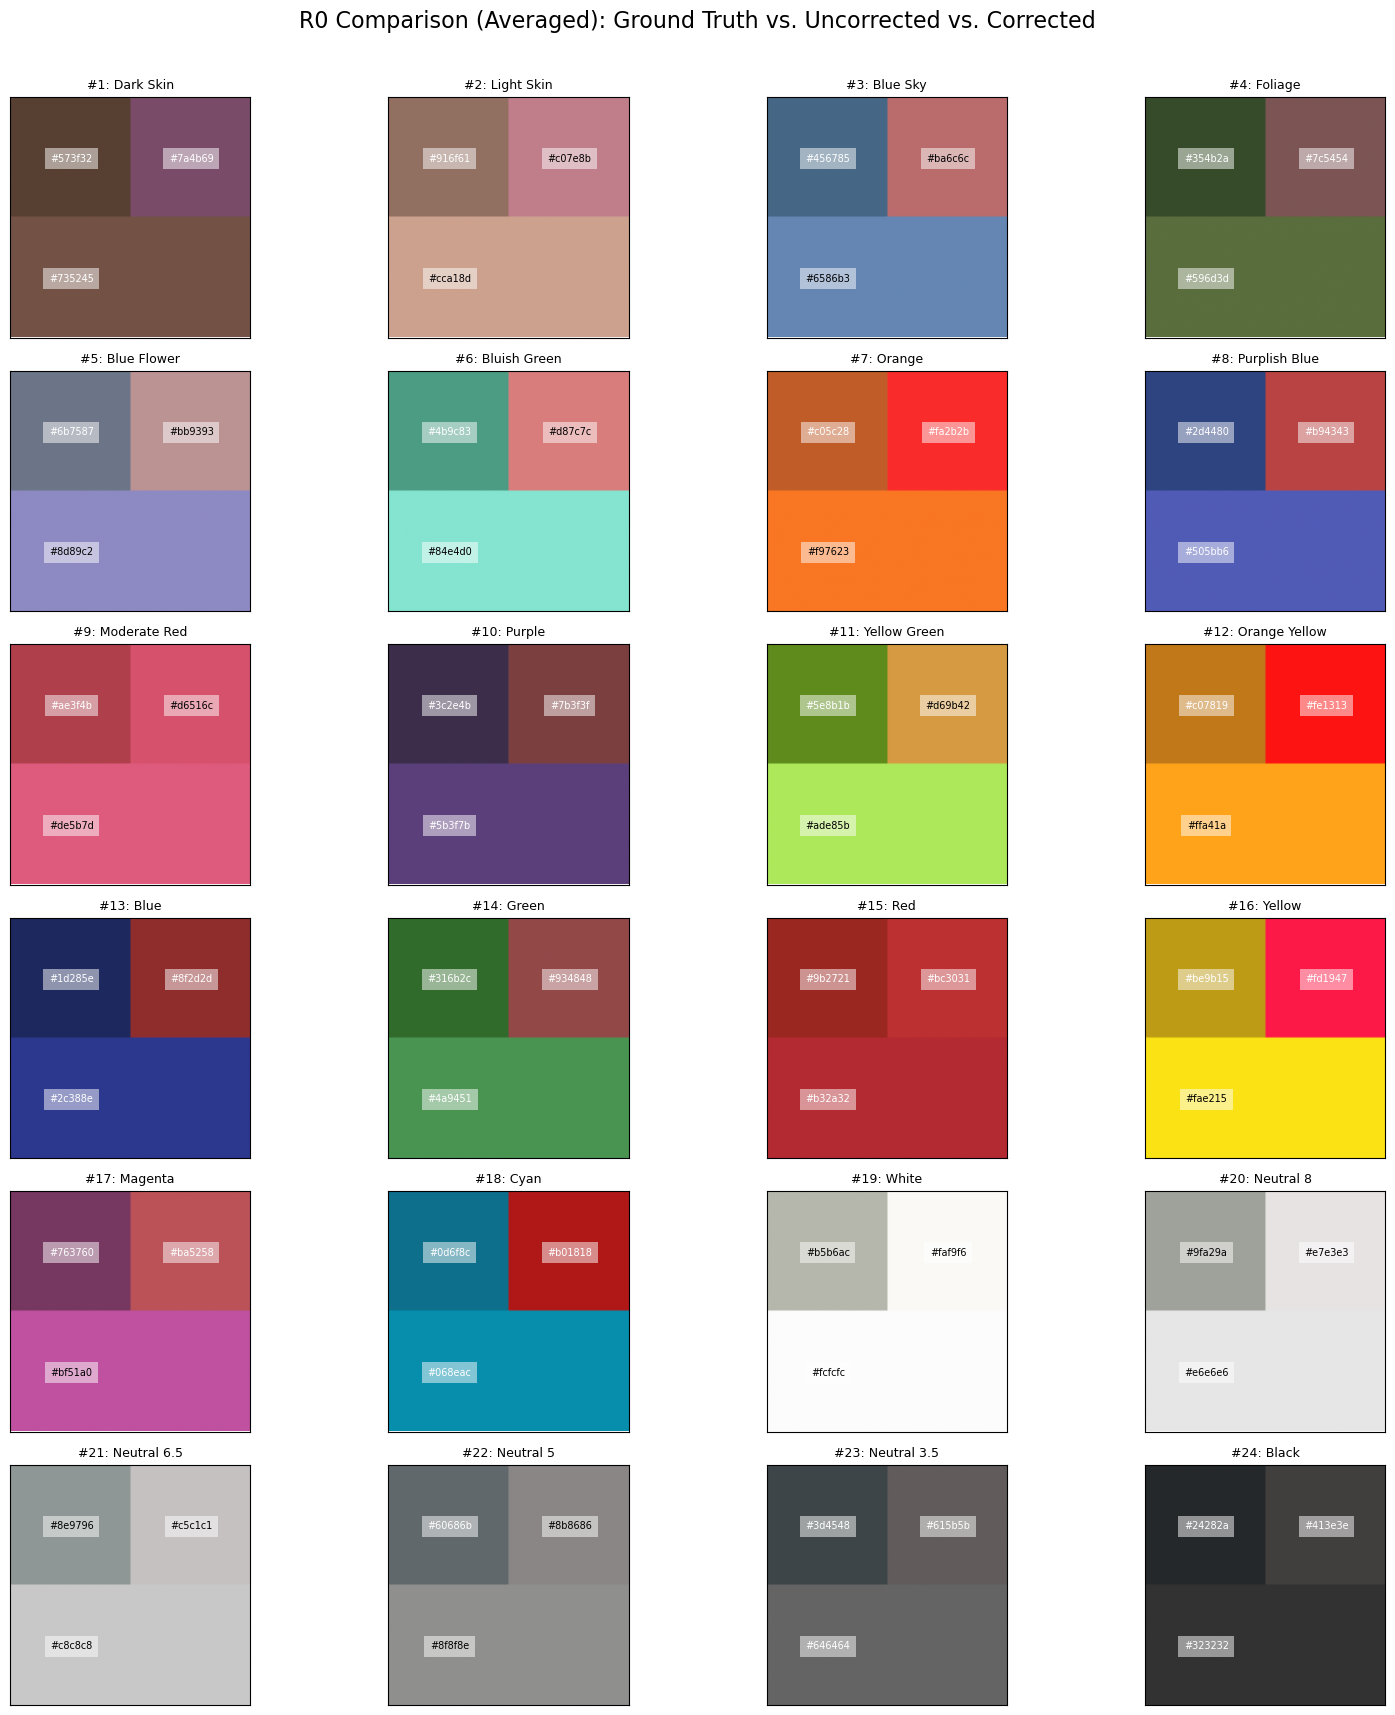

Plotting 24 unique samples for radius r2.


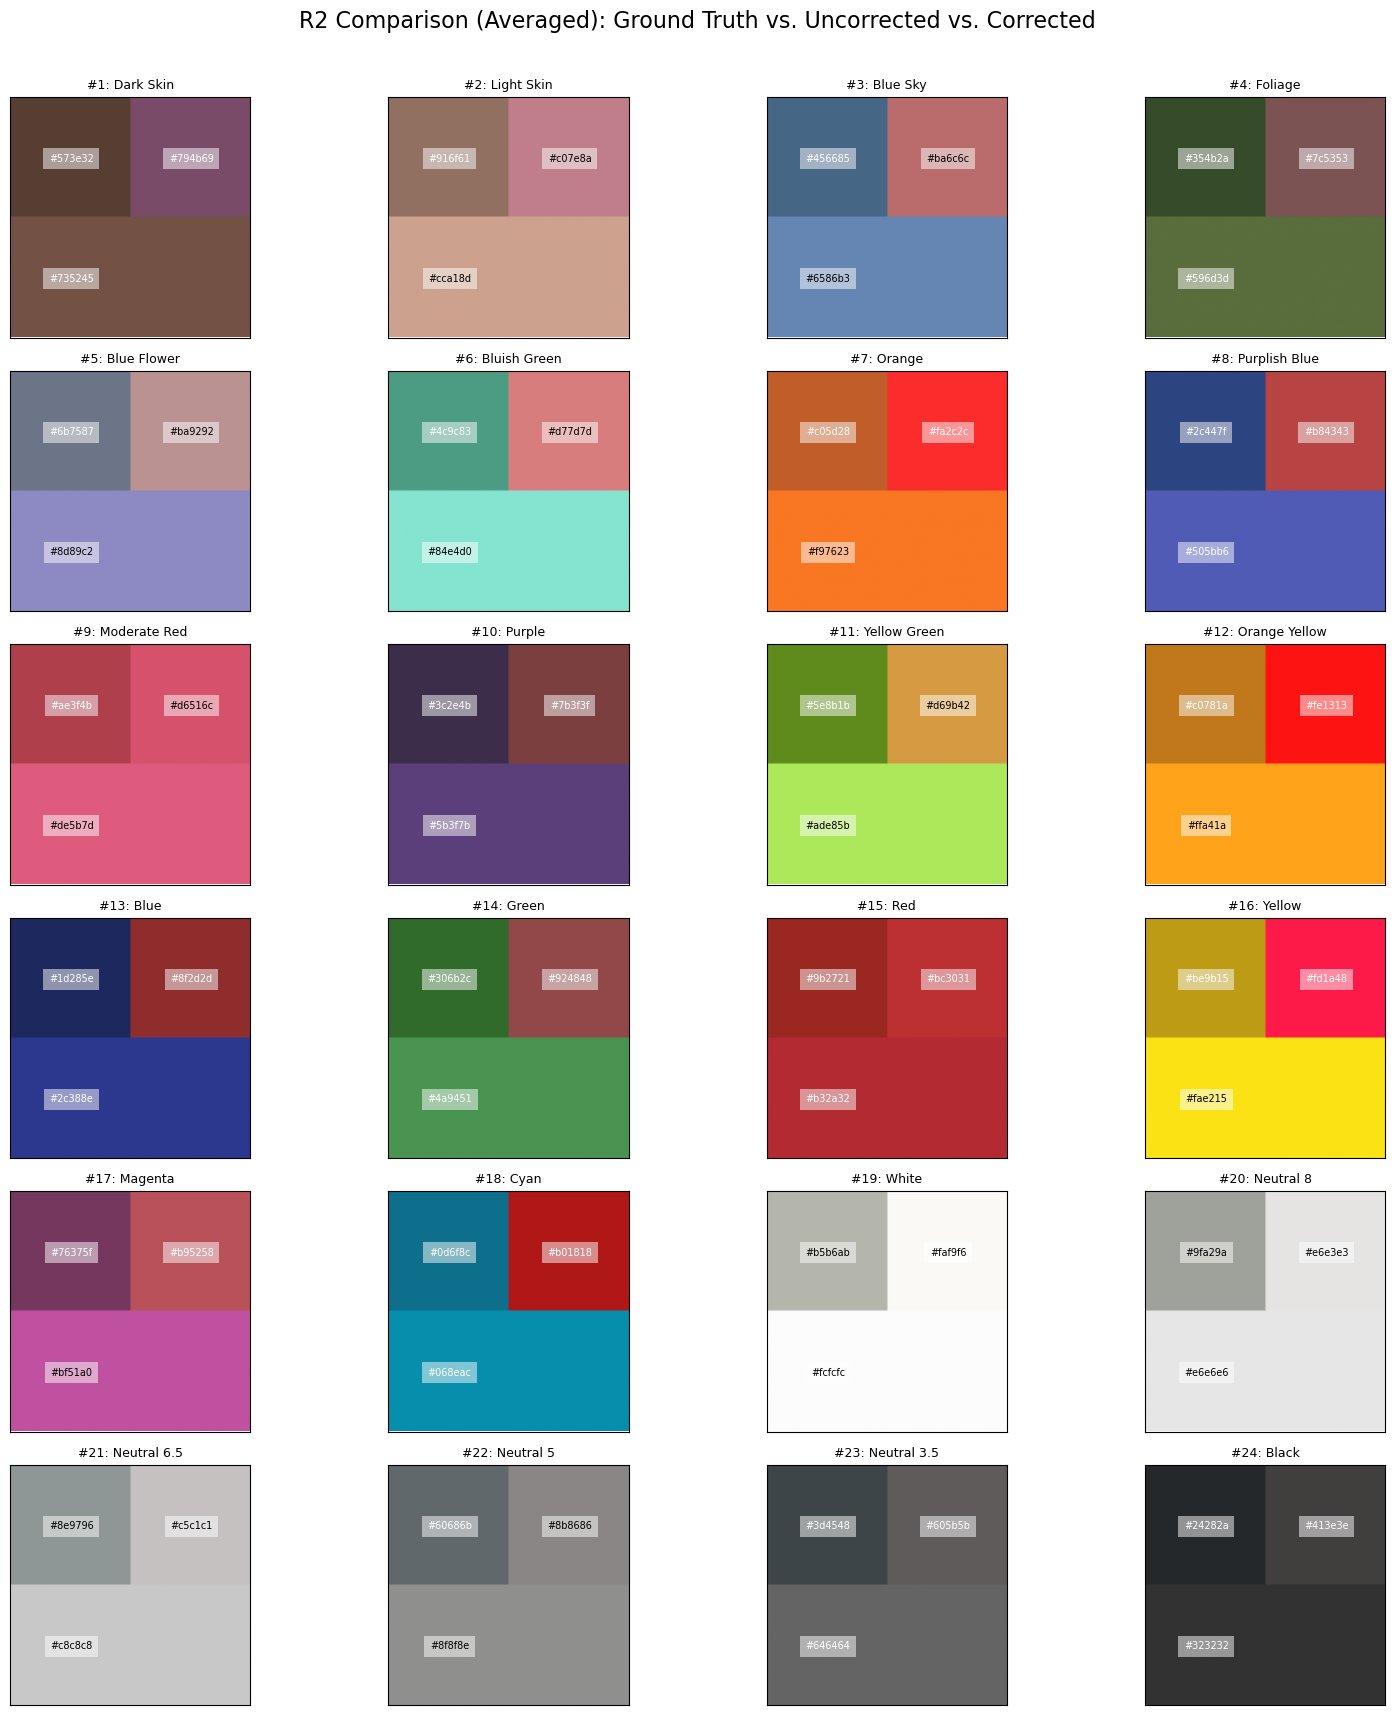

Plotting 24 unique samples for radius r4.


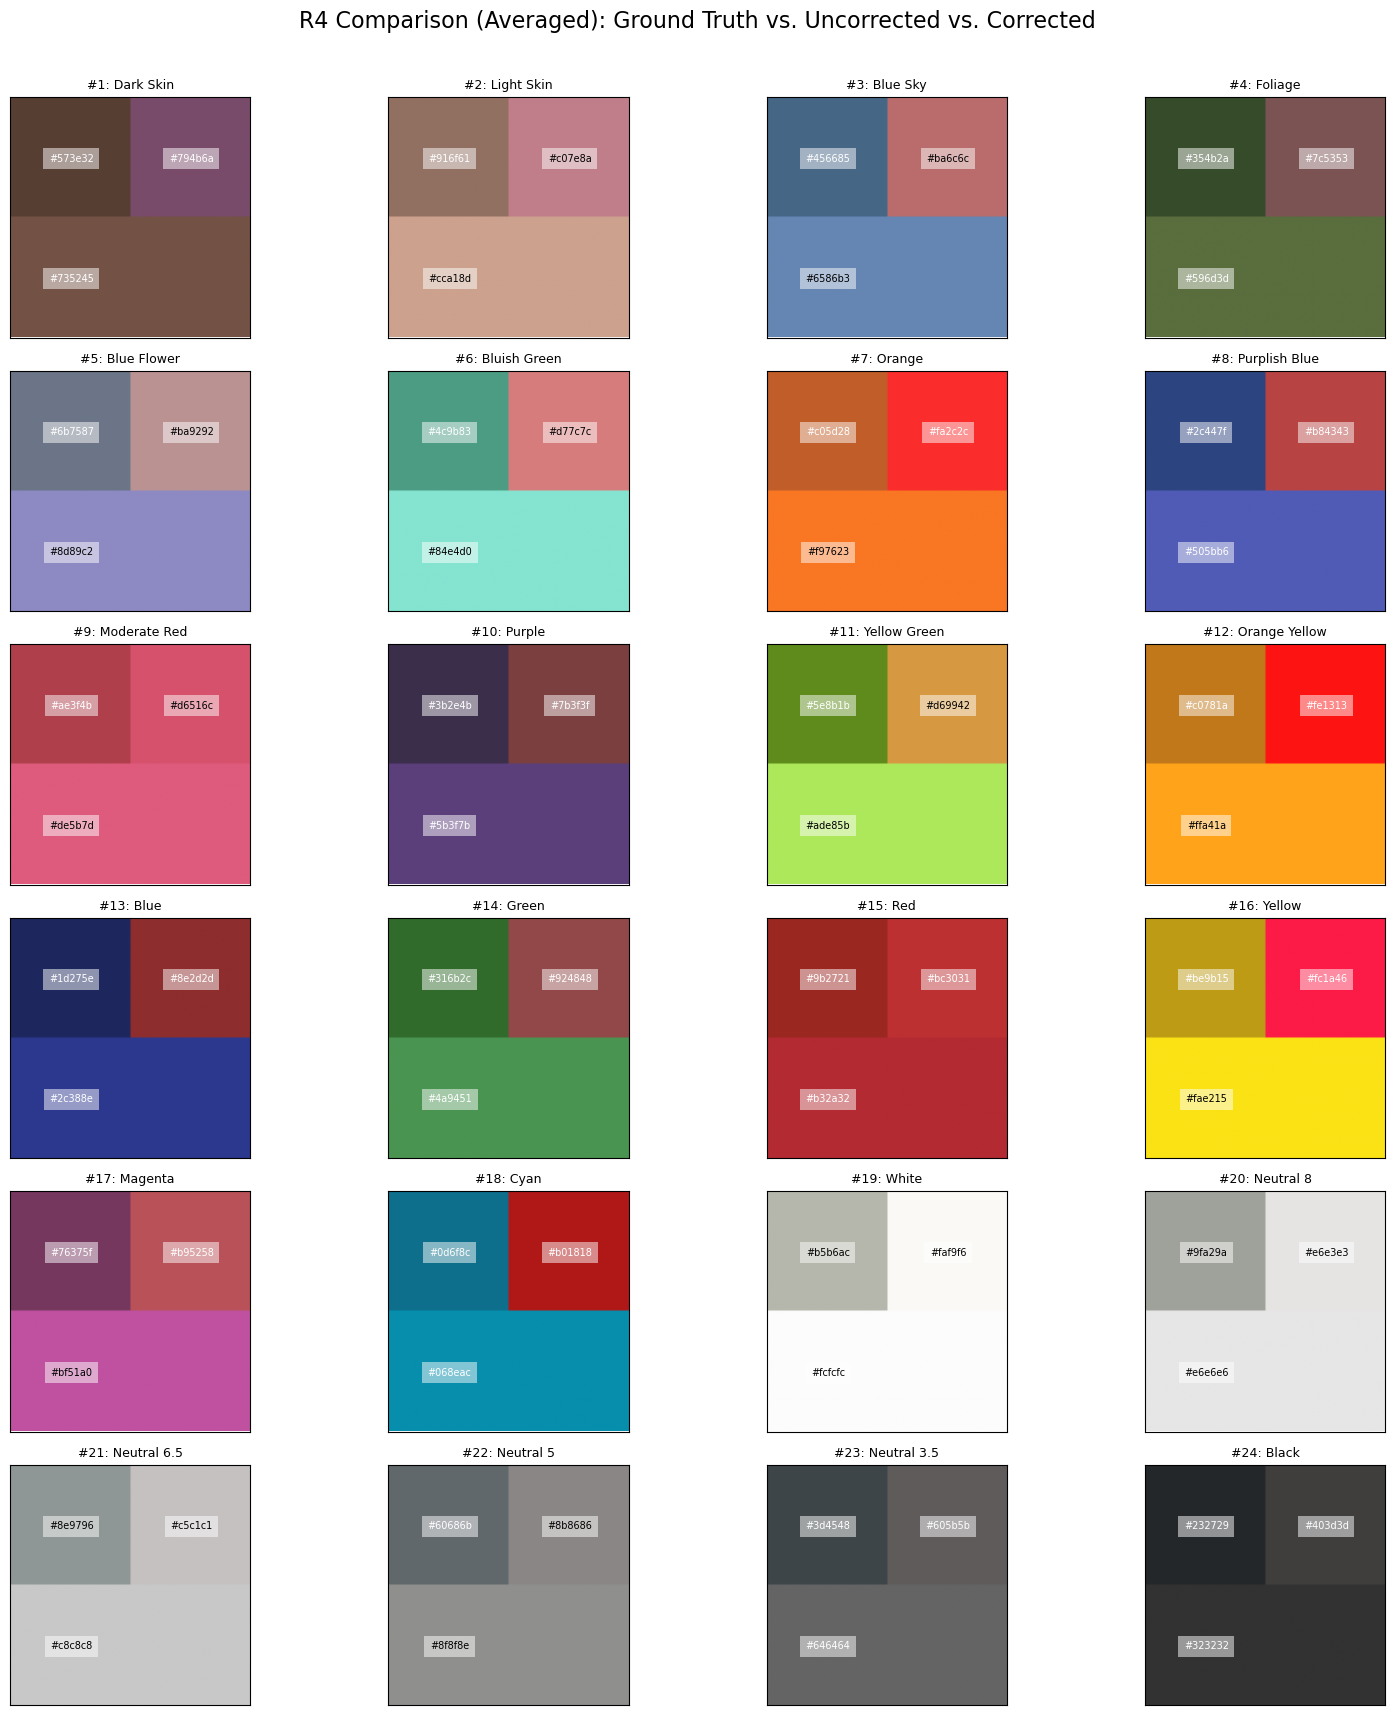

In [17]:
plotAllRadius(df_final_comparison)
# Not visually clear for human's eyes. But the MSE has decreased. A meticulous analysis would yield this is better.

In [18]:
def convert_rgb_to_hsv(r, g, b):
    # Normalize RGB values to 0-1 range
    normalized_rgb = np.array([r, g, b]) / 255.0
    # Convert to HSV
    hsv = rgb_to_hsv(normalized_rgb)
    return hsv[0], hsv[1], hsv[2]

# Apply to Ground Truth colors
def df_HSV(df_final_comparison):
  df_final_comparison[['gt__H', 'gt__S', 'gt__V']] = df_final_comparison.apply(
      lambda row: convert_rgb_to_hsv(row['gt__R'], row['gt__G'], row['gt__B']),
      axis=1,
      result_type='expand'
  )

  # Apply to Uncorrected colors
  df_final_comparison[['uncorr_H', 'uncorr_S', 'uncorr_V']] = df_final_comparison.apply(
      lambda row: convert_rgb_to_hsv(row['color_r2_R'], row['color_r2_G'], row['color_r2_B']),
      axis=1,
      result_type='expand'
  )

  # Apply to Corrected colors
  df_final_comparison[['corr_H', 'corr_S', 'corr_V']] = df_final_comparison.apply(
      lambda row: convert_rgb_to_hsv(row['correction_r2_R'], row['correction_r2_G'], row['correction_r2_B']),
      axis=1,
      result_type='expand'
  )

  # Calculate H_error considering the circular nature of Hue (normalized to 0-1)
  h_diff_uncorr = np.abs(df_final_comparison['uncorr_H'] - df_final_comparison['gt__H'])
  df_final_comparison['H_error_uncorr'] = np.minimum(h_diff_uncorr, 1 - h_diff_uncorr)

  h_diff_corr = np.abs(df_final_comparison['corr_H'] - df_final_comparison['gt__H'])
  df_final_comparison['H_error_corr'] = np.minimum(h_diff_corr, 1 - h_diff_corr)

  df_final_comparison['S_error_uncorr'] = df_final_comparison['uncorr_S'] - df_final_comparison['gt__S']
  df_final_comparison['S_error_corr'] = df_final_comparison['corr_S'] - df_final_comparison['gt__S']

  df_final_comparison['V_error_uncorr'] = df_final_comparison['uncorr_V'] - df_final_comparison['gt__V']
  df_final_comparison['V_error_corr'] = df_final_comparison['corr_V'] - df_final_comparison['gt__V']
  return df_final_comparison

In [19]:
# Define the HSV components to plot
def plotHSV(df_final_comparison):
  hsv_components = ['H', 'S', 'V']

  for component in hsv_components:
      plt.figure(figsize=(10, 6))

      # Uncorrected error column name
      uncorr_error_col = f'{component}_error_uncorr'
      # Corrected error column name
      corr_error_col = f'{component}_error_corr'

      # Plot uncorrected error distribution
      sns.kdeplot(x=df_final_comparison[uncorr_error_col],
              fill=True,
              color='blue',
              label='Uncorrected',
              alpha=0.2,
              common_norm=False)

      # Plot corrected error distribution
      #sns.histplot(df_final_comparison[corr_error_col], kde=True, color='red', label='Corrected', alpha=0.6, stat='density', common_norm=False)

      sns.kdeplot(x=df_final_comparison[corr_error_col],
              fill=True,
              color='red',
              label='Corrected',
              alpha=0.2,
              common_norm=False)

      # Calculate mean and standard deviation for both distributions
      mean_uncorr = df_final_comparison[uncorr_error_col].mean()
      std_uncorr = df_final_comparison[uncorr_error_col].std()

      mean_corr = df_final_comparison[corr_error_col].mean()
      std_corr = df_final_comparison[corr_error_col].std()

      # Add text annotations for mean and std dev
      plt.axvline(mean_uncorr, color='blue', linestyle='dashed', linewidth=1)
      plt.text(mean_uncorr + 0.01, plt.ylim()[1]*0.9, f'Mean Uncorr: {mean_uncorr:.3f}', color='blue', fontsize=10)
      plt.text(mean_uncorr + 0.01, plt.ylim()[1]*0.85, f'Std Uncorr: {std_uncorr:.3f}', color='blue', fontsize=10)

      plt.axvline(mean_corr, color='red', linestyle='dashed', linewidth=1)
      plt.text(mean_corr + 0.01, plt.ylim()[1]*0.75, f'Mean Corr: {mean_corr:.3f}', color='red', fontsize=10)
      plt.text(mean_corr + 0.01, plt.ylim()[1]*0.7, f'Std Corr: {std_corr:.3f}', color='red', fontsize=10)

      # Set title and labels
      plt.title(f'Distribution of {component} Error: Uncorrected vs. Corrected')
      plt.xlabel('Error Value')
      plt.ylabel('Density')
      plt.legend()
      plt.grid(True, linestyle='--', alpha=0.7)
      plt.tight_layout()
      plt.show()


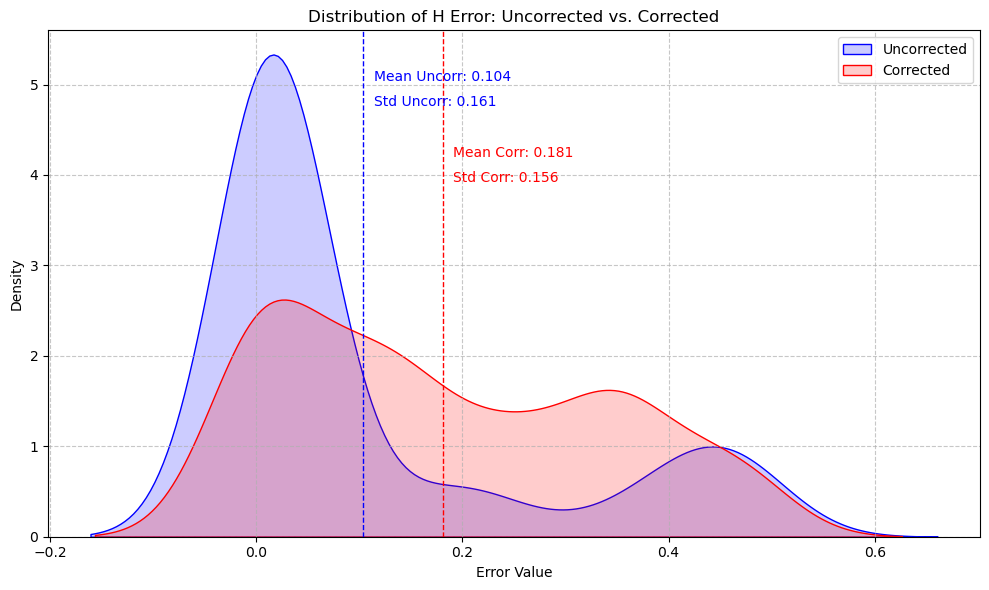

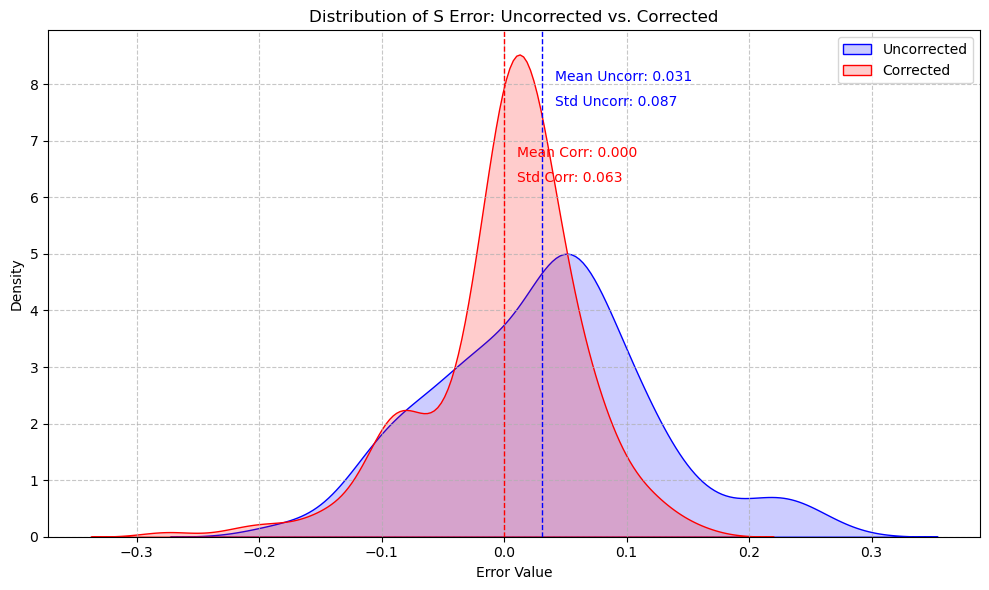

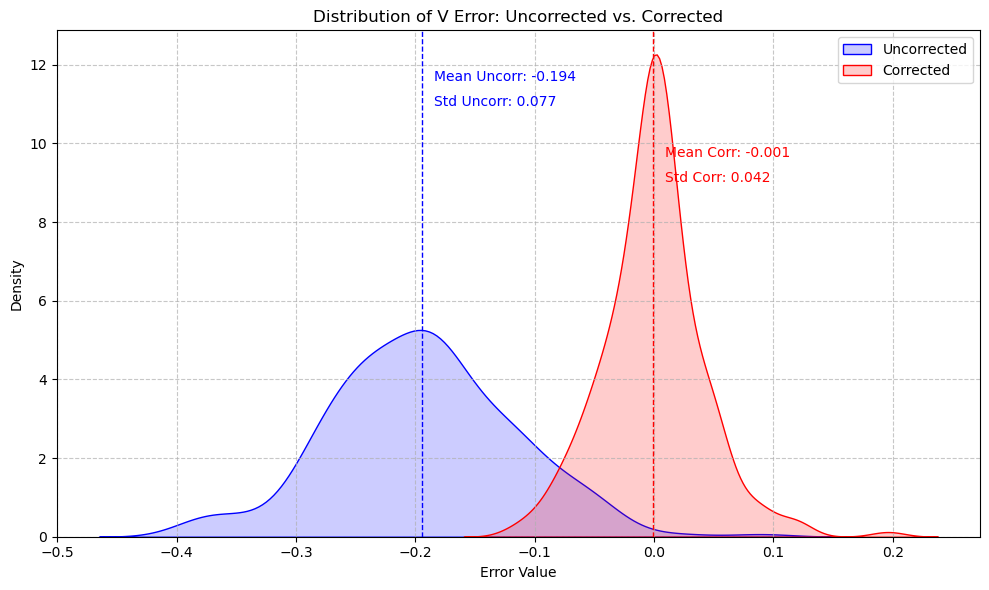

In [20]:
df = df_HSV(df)
plotHSV(df)

In [21]:

print("\nNew Polynomial Correction MSE:")
mse_r = mean_squared_error(df['gt__R'], df['correction_r4_R'])
mse_g = mean_squared_error(df['gt__G'], df['correction_r4_G'])
mse_b = mean_squared_error(df['gt__B'], df['correction_r4_B'])

avg_mse = (mse_r + mse_g + mse_b) / 3.0

print(f"  R channel MSE: {mse_r:.2f}")
print(f"  G channel MSE: {mse_g:.2f}")
print(f"  B channel MSE: {mse_b:.2f}")
print(f"  Average MSE : {avg_mse:.2f}")


New Polynomial Correction MSE:
  R channel MSE: 3216.36
  G channel MSE: 4546.52
  B channel MSE: 3398.43
  Average MSE : 3720.44
